In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import time
import numpy as np
import matplotlib.pyplot as plt


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Hyperparameters
batch_size = 128
patch_size = 4  # We'll split the 28x28 image into 7x7 patches
num_patches = (28 // patch_size) ** 2
embed_dim = 64
num_heads = 4
num_layers = 3
mlp_dim = 128
num_classes = 10
dropout = 0.1
learning_rate = 0.003
num_epochs = 50

# Load and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='mnist_dataset/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_dataset/', train=False, transform=transform, download=True)

# Split training dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Training Images:


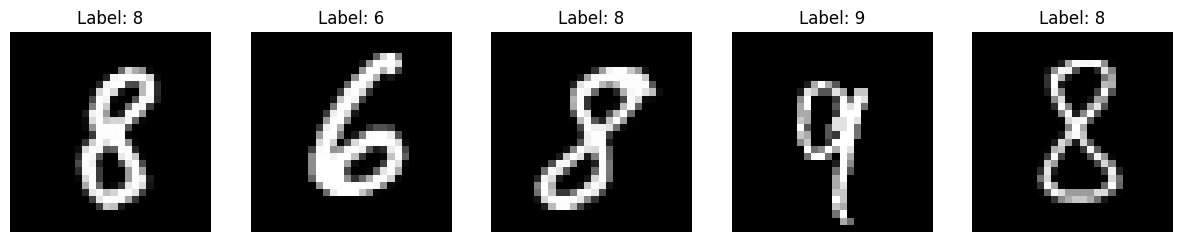

Validation Images:


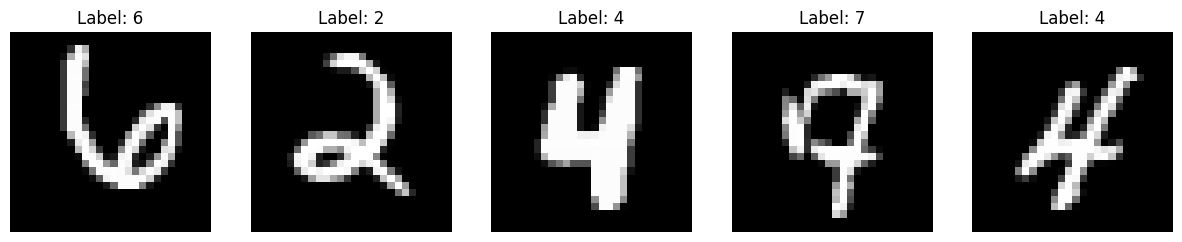

In [3]:
# Function to visualize 5 random images with their labels
def visualize_random_images(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax in axes:
        index = np.random.randint(0, len(dataset))
        img, label = dataset[index]
        img = img.numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Visualize training and validation images
print("Training Images:")
visualize_random_images(train_dataset)
print("Validation Images:")
visualize_random_images(val_dataset)

In [4]:
# Vision Transformer Model
class ViT(nn.Module):
    def __init__(self, patch_size, num_patches, embed_dim, num_heads, num_layers, mlp_dim, num_classes, dropout):
        super(ViT, self).__init__()
        self.patch_size = patch_size

        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu'  # Changed activation to GELU
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]  # Use only the cls token for classification
        x = self.mlp_head(x)
        return x


In [5]:
# Initialize the ViT model
model = ViT(patch_size, num_patches, embed_dim, num_heads, num_layers, mlp_dim, num_classes, dropout).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Changed to AdamW with weight decay

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

/Users/abhi_mac/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
# Training and evaluation functions
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(loader), correct / total


In [7]:

# Training loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [8]:
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

Epoch [1/50]: Train Loss: 2.3146, Train Acc: 0.1045, Val Loss: 2.3058, Val Acc: 0.1013
Epoch [2/50]: Train Loss: 2.3045, Train Acc: 0.1055, Val Loss: 2.3029, Val Acc: 0.1123
Epoch [3/50]: Train Loss: 2.3029, Train Acc: 0.1102, Val Loss: 2.3031, Val Acc: 0.1123
Epoch [4/50]: Train Loss: 2.3025, Train Acc: 0.1120, Val Loss: 2.3013, Val Acc: 0.1123
Epoch [5/50]: Train Loss: 2.3019, Train Acc: 0.1097, Val Loss: 2.3020, Val Acc: 0.1123
Epoch [6/50]: Train Loss: 2.3018, Train Acc: 0.1116, Val Loss: 2.3010, Val Acc: 0.1123
Epoch [7/50]: Train Loss: 2.3019, Train Acc: 0.1115, Val Loss: 2.3011, Val Acc: 0.1123


In [ ]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Function to visualize predictions
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = images[i].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
        axes[i].axis('off')
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader)